In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import TargetEncoder, StandardScaler
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [118]:
KERNELS = ['linear', 'poly', 'rbf', 'sigmoid']

# resolution 0 is census tracts
RESOLUTIONS = [0, 3, 4, 5, 6, 7, 8, 9]
TARGETS = ['demand_target_bucket_1', 'demand_target_bucket_2', 'demand_target_bucket_6', 'demand_target_bucket_24']

In [82]:
FEATURES = ['trip_start_hour', 'trip_start_month',
       'trip_start_day', 'temp', 'humidity', 'wind_speed',
       'wind_gust', 'pressure', 'precip', 'Clear/Sunny',
       'Cloudy', 'Other', 'Rain/Storms',
       'Snow/Winter Conditions', 'temp_h-1', 'precip_h-1', 'autumn',
       'spring', 'summer', 'winter', 'weekend',
       'afternoon_week', 'afternoon_weekend', 'evening_week',
       'evening_weekend', 'morning_week', 'morning_weekend', 'night_week',
       'night_weekend', 'is_holiday', 'demand_h-1', 'demand_h-2',
       'demand_h-24', 'demand_p-24', 'demand_bucket_2', 'demand_bucket_6',
       'demand_bucket_24']

In [67]:
def get_X_y(df, prediction_horizon):
    y = df[f'demand_target_bucket_{prediction_horizon}']
    X = df[FEATURES +[f'pickup_demand_target_bucket_{prediction_horizon}']]
    
    return X, y

In [73]:
def scale_data(X_train, X_test=None):
    # Create the scaler
    scaler = StandardScaler()

    # Fit the scaler using the training data
    scaler.fit(X_train)

    # Transform both the training and test data
    X_train_scaled = scaler.transform(X_train)
    if X_test:
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled
    return X_train_scaled

In [72]:
def get_df_by_resolution(resolution, census=False):
    if census:
        df_train = pd.read_csv('./data/model_input/0_res_train.csv')
        df_test = pd.read_csv('./data/model_input/0_res_test.csv')
        return df_train, df_test
    
    df_train = pd.read_csv(f'./data/model_input/{resolution}_res_train.csv')
    df_test = pd.read_csv(f'./data/model_input/{resolution}_res_test.csv')
    return df_train, df_test
    

In [79]:
df_train.columns

Index(['timestamp', 'pickup_loc', 'trip_start_hour', 'trip_start_month',
       'trip_start_day', 'demand', 'temp', 'humidity', 'wind_speed',
       'wind_gust', 'pressure', 'precip', 'Clear/Sunny', 'Cloudy', 'Other',
       'Rain/Storms', 'Snow/Winter Conditions', 'temp_h-1', 'temp_h-2',
       'temp_h-3', 'precip_h-1', 'precip_h-2', 'precip_h-3', 'autumn',
       'spring', 'summer', 'winter', 'weekend', 'afternoon_week',
       'afternoon_weekend', 'evening_week', 'evening_weekend', 'morning_week',
       'morning_weekend', 'night_week', 'night_weekend', 'is_holiday',
       'demand_h-1', 'demand_h-2', 'demand_h-24', 'demand_p-24',
       'demand_bucket_2', 'demand_bucket_6', 'demand_bucket_24',
       'demand_target_bucket_1', 'demand_target_bucket_2',
       'demand_target_bucket_6', 'demand_target_bucket_24',
       'pickup_demand_target_bucket_1', 'pickup_demand_target_bucket_2',
       'pickup_demand_target_bucket_6', 'pickup_demand_target_bucket_24'],
      dtype='object')

## Identify best Kernel

In [117]:
df_train, df_test = get_df_by_resolution(3)
X_train, y_train = get_X_y(df_train, 1)
X_train_scaled = scale_data(X_train)

# Define hyperparameter grid for each kernel
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale']},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['auto', 'scale']},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10], 'gamma': ['auto']}
]


# Create GridSearchCV object
grid_search = GridSearchCV(SVR(epsilon=0.1), param_grid, cv=5, verbose=2, scoring='neg_root_mean_squared_error')

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   6.3s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.5s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.3s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.3s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.5s
[CV] END .................................C=1, kernel=linear; total time=   6.5s
[CV] END .................................C=1, kernel=linear; total time=   5.7s
[CV] END .................................C=1, kernel=linear; total time=   5.7s
[CV] END .................................C=1, kernel=linear; total time=   5.6s
[CV] END .................................C=1, kernel=linear; total time=   5.6s
[CV] END ................................C=10, kernel=linear; total time=   8.1s
[CV] END ................................C=10, k

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'degree': [2, 3],
                          'gamma': ['scale'], 'kernel': ['poly']},
                         {'C': [0.1, 1, 10], 'gamma': ['auto', 'scale'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'gamma': ['auto'],
                          'kernel': ['sigmoid']}],
             scoring='neg_root_mean_squared_error', verbose=2)

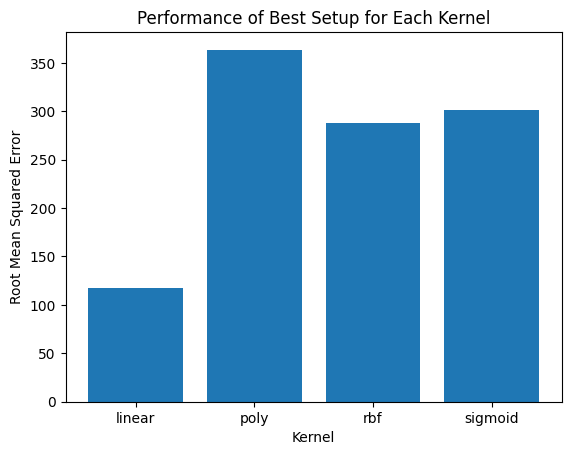

In [121]:
# Extract the results
cv_results = grid_search.cv_results_

# Create empty lists to hold the results for each kernel
scores = []
KERNELS = ['linear', 'poly', 'rbf', 'sigmoid']
# Iterate over the kernels to find the best score for each
for kernel in KERNELS:
    kernel_mask = [param['kernel'] == kernel for param in cv_results['params']]
    kernel_scores = cv_results['mean_test_score'][kernel_mask]
    best_kernel_score = max(kernel_scores)
    scores.append(best_kernel_score)

# Plot the results
plt.bar(KERNELS, [abs(score) for score in scores])
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Kernel')
plt.title('Performance of Best Setup for Each Kernel')
plt.show()

In [ ]:
RESOLUTIONS = [0, 3, 4, 5, 6, 7, 8, 9]
TARGET_HORIOZONS = [1, 2, 6, 24]

for resolution in RESOLUTIONS:
    for horizon in TARGET_HORIOZONS:   
        # get data
        df_train, df_test = get_df_by_resolution(resolution)
        X_train, y_train = get_X_y(df_train, TARGET_HORIOZONS)
        X_train, y_train = get_X_y(df_test, TARGET_HORIOZONS)
        X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
    

In [131]:
RESOLUTIONS = [0, 3, 4, 5, 6, 7, 8, 9]
TARGET_HORIOZONS = [1, 2, 6, 24]

RESOLUTIONS = [0, 3]
TARGET_HORIOZONS = [1, 2]
# DataFrame to store results
results_df = pd.DataFrame(columns=['Resolution', 'Target Horizon', 'RMSE'])

for resolution in RESOLUTIONS:
    rmse_per_horizon = []
    for horizon in TARGET_HORIOZONS:
        print(f'RESOLUTION:{resolution} - HORIZON: {horizon}')
        # Get and preprocess data
        df_train, df_test = get_df_by_resolution(resolution)
        X_train, y_train = get_X_y(df_train, horizon)
        X_test, y_test = get_X_y(df_test, horizon)
        X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

        # Define and train SVR
        param_grid = [
            {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale']}
        ]
        grid_search = GridSearchCV(SVR(), param_grid, scoring='neg_root_mean_squared_error', cv=5)
        grid_search.fit(X_train_scaled, y_train)

        # Calculate RMSE
        y_pred = grid_search.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Store results
        results_df = results_df.append({'Resolution': resolution, 'Target Horizon': horizon, 'RMSE': rmse}, ignore_index=True)
        rmse_per_horizon.append(rmse)

    # Plot results for current resolution
    plt.plot(TARGET_HORIOZONS, rmse_per_horizon, label=f'Resolution {resolution}')
    plt.xlabel('Target Horizon')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Target Horizon')
    plt.legend()

plt.show()


RESOLUTION:0 - HORIZON: 1


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().